# Apply a gaussian shape to each sample

We implement an idea presented in [InDeep : 3D fully convolutional neural networks to assist in silico drug design on protein-protein interactions](https://www.biorxiv.org/content/10.1101/2021.07.28.453974v1.full), published in **BioInformatics**.

The idea is to "spread" the influence of the atoms into their neighbourhood. To do so, we will update the following columns in the tabular data:

* 'B', 'C', 'N', 'O', 'P', 'S', 'Se', 'halogen', 'metal', 'hydrophobic', 'aromatic': will get a "Gaussian" treatement (see [Radial basis kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)) 
* 'molcode': will be spread as well as '0' or '1' (either a protein or a ligand) -- NOT DONE

---

## Setup

We will demonstrate the transformation on a simple sample, transformed into a 3D array and normalized.

In [2]:
%load_ext autoreload
%autoreload 2

import os
from math import ceil
from random import randint
from pathlib import Path
import numpy as np
from sklearn.gaussian_process.kernels import RBF
#from rich.jupyter import print
import matplotlib.pyplot as plt
%matplotlib inline

working_dir = os.environ['SCRATCH']
input_csv = os.path.join(working_dir, 'data/frugalpython/CoG_14_original/validation_csv')

column_names = ['x', 'y', 'z', 'B', 'C', 'N', 'O', 'P', 'S', 'Se', 'halogen', 'metal', \
                 'hyb', 'heavyvalence', 'heterovalence', 'partialcharge', 'molcode', \
                 'hydrophobic', 'aromatic', 'acceptor', 'donor', 'ring'] 
feature_names = ['B', 'C', 'N', 'O', 'P', 'S', 'Se', 'halogen', 'metal', \
                 'hyb', 'heavyvalence', 'heterovalence', 'partialcharge', 'molcode', \
                 'hydrophobic', 'aromatic', 'acceptor', 'donor', 'ring'] 

columns_dict = {name: i for i, name in enumerate(column_names)}
features_dict = {name: i for i, name in enumerate(feature_names)}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_random_sample():
    #files = [f for f in os.listdir(input_csv) if f.endswith('.csv')]
    #r = randint(0, len(files)-1)
    #selected_file = files[r]
    selected_file = "1o86.csv"
    filename = os.path.join(input_csv, selected_file)
    data = np.genfromtxt(filename, delimiter=' ')
    print(f"Selected sample {selected_file}, containing {data.shape[0]} rows")
    return data   

In [4]:
sample = get_random_sample()

Selected sample 1o86.csv, containing 923 rows


In [5]:
# checking that all rows have at least one atom defined
atoms = ['B', 'C', 'N', 'O', 'P', 'S', 'Se', 'halogen', 'metal']

selection = {key: value for (key, value) in columns_dict.items() if key in atoms}

def check_atom(row):
    atoms_found = int(sum(row[value] for value in selection.values()))
    if atoms_found !=1:
        print(f"Found multiple atoms in row {atoms_found=}")
        return False
    return 1

for r in sample:
    res = check_atom(r)
    if not(res): 
        break


## Using sklearn kernel

Steps:

* create final grid
* for each atom build a kernel then apply to grid
* plot result

### Demo

Lets build a Gaussian kernel using all the positions of atoms **C**, which is column 4:

In [6]:
# end result will be a cube with 1.0 Angstrom between 2 points and a 
# shape of 2*max_dist + 1 (maximum distance between atom and box center)
spacing, max_dist = 1.0, 12.0
coords = sample[:,:3]

# get dimension of sample
xyz_min = coords.min(axis=0)
xyz_max = coords.max(axis=0)
xyz_center = (xyz_max + xyz_min)/2.0
print(f"Dimension of the protein-ligand: {xyz_min} x {xyz_max} with a center at {xyz_center}") 

# filter dimension so it fits a bounding box of max 25 Angstrom per side
in_box = ((coords >= xyz_center -0.5 - max_dist) & (coords <= xyz_center +0.5 + max_dist)).all(axis=1) # TODO : set max_dist=13 (-->shape 25x25x25)
filtered_sample = sample[in_box]
filtered_coords = filtered_sample[:,:3]
print(f" sample {filtered_sample.shape} coords {filtered_coords.shape}")
xyz_min = filtered_coords.min(axis=0)
xyz_max = filtered_coords.max(axis=0)
xyz_center = (xyz_max + xyz_min)/2.0
print(f"Dimension of the protein-ligand filtered: {xyz_min} x {xyz_max} with a new center at {xyz_center}") 


# build a grid 
def get_grid_shape(xyz_min, xyz_max):
    xm, ym, zm = xyz_min 
    xM, yM, zM = xyz_max 
    X = np.arange(xm, xM, spacing)
    Y = np.arange(ym, yM, spacing)
    Z = np.arange(zm, zM, spacing)
    nx, ny, nz = len(X) - 1, len(Y) - 1, len(Z) - 1
    print(X)
    return nx, ny, nz

grid_shape = get_grid_shape(xyz_min, xyz_max)
grid_shape


Dimension of the protein-ligand: [-18.04 -16.82 -15.29] x [20.43 20.57 18.99] with a center at [1.195 1.875 1.85 ]
 sample (655, 22) coords (655, 3)
Dimension of the protein-ligand filtered: [-11.2  -10.61 -10.63] x [13.68 14.28 14.18] with a new center at [1.24  1.835 1.775]
[-11.2 -10.2  -9.2  -8.2  -7.2  -6.2  -5.2  -4.2  -3.2  -2.2  -1.2  -0.2
   0.8   1.8   2.8   3.8   4.8   5.8   6.8   7.8   8.8   9.8  10.8  11.8
  12.8]


(24, 24, 24)

In [7]:
# get only atoms of type atom
atom_name = 'C'
print(f"{atom_name=} is at columns: {columns_dict[atom_name]}")
all_atoms_of_interest = filtered_sample[:,columns_dict[atom_name]]>0
filtered_sample_with_atom = filtered_sample[all_atoms_of_interest]
filtered_coords_with_atom = filtered_sample_with_atom[:,:3]
print(f"{len(filtered_sample_with_atom)=} {sum(all_atoms_of_interest)=}")

#filtered_coords

atom_name='C' is at columns: 4
len(filtered_sample_with_atom)=404 sum(all_atoms_of_interest)=404


In [8]:
def get_bins(coords, spacing, padding, xyz_min=None, xyz_max=None):
    xm, ym, zm = xyz_min
    xM, yM, zM = xyz_max

    xi = np.arange(xm, xM, spacing)
    yi = np.arange(ym, yM, spacing)
    zi = np.arange(zm, zM, spacing)
    return xi, yi, zi

xi, yi, zi = get_bins(filtered_coords_with_atom, spacing, max_dist, xyz_min, xyz_max)
#grid = gaussian_blur(coords, xi, yi, zi, sigma=sigma)

len(xi)
xi

array([-11.2, -10.2,  -9.2,  -8.2,  -7.2,  -6.2,  -5.2,  -4.2,  -3.2,
        -2.2,  -1.2,  -0.2,   0.8,   1.8,   2.8,   3.8,   4.8,   5.8,
         6.8,   7.8,   8.8,   9.8,  10.8,  11.8,  12.8])

In [9]:
def just_one(coord, xi, yi, zi, sigma, total_grid):
    #  Find subgrid
    nx, ny, nz = xi.size, yi.size, zi.size

    bound = int(2 * sigma) # extend of the gaussian originally 4
    
    x, y, z = coord # only one coord at a time
    binx = np.digitize(x, bins=xi) # Return the indices of the bins to which each value in input array belongs.
    biny = np.digitize(y, yi)
    binz = np.digitize(z, zi)
    #print(f"Bin {binx.shape=} {biny.shape=} {binz.shape=} ")

    min_bounds_x, max_bounds_x = max(0, binx - bound), min(nx, binx + bound) 
    min_bounds_y, max_bounds_y = max(0, biny - bound), min(ny, biny + bound)
    min_bounds_z, max_bounds_z = max(0, binz - bound), min(nz, binz + bound)
    #print(f"bounds: {min_bounds_z=} {max_bounds_z=} for {binz=} and {bound=}")
    
    X, Y, Z = np.meshgrid(xi[min_bounds_x: max_bounds_x],
                          yi[min_bounds_y: max_bounds_y],
                          zi[min_bounds_z:max_bounds_z],
                          indexing='ij')
    X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()

    #  Compute RBF
    rbf = RBF(sigma)
    subgrid = rbf(coord, np.c_[X, Y, Z])
    subgrid = subgrid.reshape((max_bounds_x - min_bounds_x,
                               max_bounds_y - min_bounds_y,
                               max_bounds_z - min_bounds_z))

    #  Add on the first grid
    #print(coord)
    
    total_grid[min_bounds_x: max_bounds_x, min_bounds_y: max_bounds_y, min_bounds_z:max_bounds_z] += subgrid
    #print(total_grid[:,:,binz])
    return total_grid

In [10]:
def gaussian_blur(coords, xi, yi, zi, sigma=1.):
    """
    Compute RBF on a set of coords,
    We loop over each coord to compute only a neighborhood and add it to the right grid
    """

    nx, ny, nz = xi.size, yi.size, zi.size
    total_grid = np.zeros(shape=(nx, ny, nz))
    for coord in coords:
        just_one(coord, xi=xi, yi=yi, zi=zi, sigma=sigma, total_grid=total_grid)

    return total_grid


In [11]:
total_grid = gaussian_blur(filtered_coords_with_atom, xi, yi, zi)
#total_grid.shape
#total_grid[:,:,12]
#print(f"Extrema: {total_grid.min()} - {total_grid.max()}")
      

### Plots

Lets plot the original data (by setting "1" at the (x,y,z) position of the atom) and compare with the gaussian result.


In [12]:
from mpl_toolkits import mplot3d

Checking plane close to atom=array([ 0.49, -0.27, -1.6 ])
Plotting z_plane=9 for atom=array([ 0.49, -0.27, -1.6 ]), xyz_center=array([1.24 , 1.835, 1.775]) z=-1.6
Shape of plane (25, 25) and len(atoms_near_plane)=83


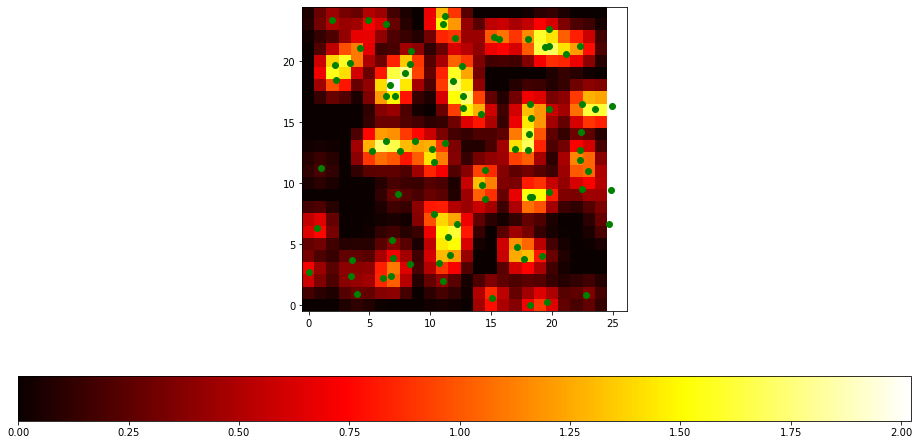

In [13]:
def plot(grid, z, coords, atom, xyz_center, xyz_min):
    shift_x, shift_y, shift_z = xyz_min
    z_plane = int(z - shift_z)
    print(f"Plotting {z_plane=} for {atom=}, {xyz_center=} {z=}")
    
    plane = grid[:,:,z_plane]
    # lets keep atoms within 2 angstrom of target
    filtering = ((coords[:,2] >= z - 2 ) & (coords[:,2] <= z + 2)) #.all(axis=1)
    
    atoms_near_plane = coords[filtering] - xyz_min
 
    print(f"Shape of plane {plane.shape} and {len(atoms_near_plane)=}")
    x,y,z = atoms_near_plane[:,0], atoms_near_plane[:,1], atoms_near_plane[:,2] 
    fig = plt.figure(figsize=(16, 8))
    
    im = plt.imshow(plane, origin='lower', cmap='hot')
    plt.scatter(y,x, color='g')
    plt.colorbar(im, orientation='horizontal')
    plt.show()
    

def view_vol(sample, z_layers, selected_feature):
    if len(z_layers)>4:
        z_layers= zlayers[:4] 
        print("Limiting z_layers to 4 planes : {z_layers}")
    planes = sample[:,:,z_layers]
    print(f"Plotting {planes.shape=}")

    
    fig = plt.figure(figsize=(18,18))
    gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
    (ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
    fig.suptitle(f'Lowest layers (1 2) on top, (3 4) on bottom')
    ax1.imshow(planes[:,:,0])
    if len(z_layers) > 1:
        ax2.imshow(planes[:,:,1],origin='lower', cmap='hot')
    if len(z_layers) > 2:
        ax3.imshow(planes[:,:,2],origin='lower', cmap='hot')
    if len(z_layers) > 3:
        ax4.imshow(planes[:,:,3],origin='lower', cmap='hot')
    for ax in fig.get_axes():
        ax.label_outer()
    plt.show()    
    
    
atom = filtered_coords_with_atom[0]
_,_,z= atom
print(f"Checking plane close to {atom=}")
plot(total_grid, z, filtered_coords_with_atom, atom, xyz_center, xyz_min)
vol_range= list(range(int(z-xyz_min[2]-1), int(z-xyz_min[2] + 3)))
#print(f"{vol_range=}")
#view_vol(total_grid, vol_range,columns_dict[atom_name])


In [14]:
# plot atoms close to plane (above and below)
def plot_with_atoms(grid, z_plane, atom_name, filtered_coords_with_atom, xyz_min):
    # grid: volume with "expanded" atoms (of selected atom)
    # z_plane: from 0 to 25 (z coordinate of grid)
    # filtered_coords_with_atom: all (x,y,z) of selected atoms
    # xyz_min: coord (0,0,0) real coordinates (for selected atom ?) TODO
    shift_x, shift_y, shift_z = xyz_min
    #z_plane = int(z - shift_z)
    z = z_plane + shift_z
    print(f"Plotting {z_plane=} for {atom_name=}, {xyz_min=}")
    
    plane = grid[:,:,z_plane]
    # lets keep atoms within 2 angstrom of target
    filtering = ((filtered_coords_with_atom[:,2] >= z - 1 ) & (filtered_coords_with_atom[:,2] <= z + 1)) #.all(axis=1)
    
    atoms_near_plane = filtered_coords_with_atom[filtering] - xyz_min
 
    print(f"Shape of plane {plane.shape} and {len(atoms_near_plane)=}")
    x,y,z = atoms_near_plane[:,0], atoms_near_plane[:,1], atoms_near_plane[:,2] 
    fig = plt.figure(figsize=(16, 8))
    
    im = plt.imshow(plane, origin='lower', cmap='hot')
    plt.scatter(y,x, color='g')
    plt.colorbar(im, orientation='horizontal')
    plt.show()
    

Plotting z_plane=4 for atom_name='C', xyz_min=array([-11.2 , -10.61, -10.63])
Shape of plane (25, 25) and len(atoms_near_plane)=41


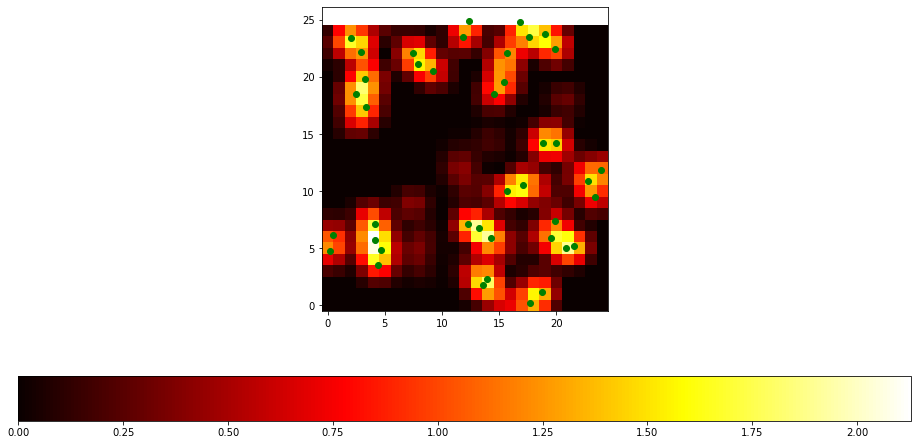

In [15]:
plot_with_atoms(total_grid, 4, atom_name, filtered_coords_with_atom, xyz_min)

In [16]:
import matplotlib.animation
import matplotlib.pyplot as plt
from itertools import count
import random

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  

(25, 25, 25)


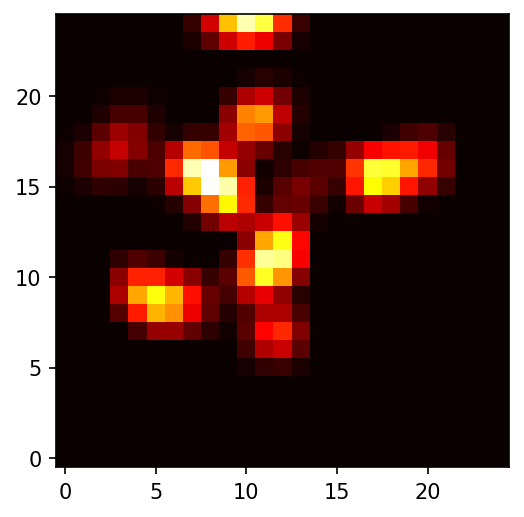

In [17]:

fig, ax = plt.subplots()

def animate(t):
    ax.cla()
    ax.imshow(total_grid[:,:,t],origin='lower', cmap='hot')

print(total_grid.shape)
matplotlib.animation.FuncAnimation(fig, animate, frames=25, interval = 500)

In [18]:
from functools import partial
from IPython.display import HTML

# animation
def animate_with_atoms(frame, grid, atom_name, filtered_coords_with_atom, xyz_min):
    # grid: volume with "expanded" atoms (of selected atom)
    # fram: from 0 to 25 (z coordinate of grid)
    # filtered_coords_with_atom: all (x,y,z) of selected atoms
    # xyz_min: coord (0,0,0) real coordinates (for selected atom ?) TODO
    
    shift_x, shift_y, shift_z = xyz_min
    #z_plane = int(z - shift_z)
    z = frame + shift_z
    #print(f"Plotting {frame=} for {atom_name=}, {xyz_min=}")
    
    plane = grid[:,:,frame]
    # lets keep atoms within 2 angstrom of target
    filtering = ((filtered_coords_with_atom[:,2] >= z - 1 ) & (filtered_coords_with_atom[:,2] <= z + 1)) #.all(axis=1)
    
    atoms_near_plane = filtered_coords_with_atom[filtering] - xyz_min
 
    #print(f"Shape of plane {plane.shape} and {len(atoms_near_plane)=}")
    x,y,z = atoms_near_plane[:,0], atoms_near_plane[:,1], atoms_near_plane[:,2] 
    ax.cla()
    ax.scatter([-1,-1,26,26], [-1,26,-1,26], color='k')
    im = ax.imshow(plane, origin='lower', cmap='hot')
    ax.scatter(y,x, color='g')
    
    #ax.colorbar(im, orientation='horizontal')
    #ax.show()

fig, ax = plt.subplots()
ax.set_xlim([-1, 30])
#ax2.autoscale_view()
ax.set_ylim([-1,26])
def animate(t):
    ax.cla()
    ax.imshow(total_grid[:,:,t],origin='lower', cmap='hot')

print(xyz_min)
ani = matplotlib.animation.FuncAnimation(fig, 
    partial(animate_with_atoms, grid=total_grid, atom_name=atom_name, filtered_coords_with_atom=filtered_coords_with_atom, xyz_min=xyz_min),
    frames=25, interval = 500)  

html = HTML(ani.to_jshtml())
display(html)
plt.close()
    

[-11.2  -10.61 -10.63]


## Building the lib for treating all the atoms and build a 3D array

* all rows have at least one of 'B', 'C', 'N', 'O', 'P', 'S', 'Se', 'halogen', 'metal' set to 1.0


In [28]:
def load_samples_from_csv(input_path):
    samples = []
    files = [os.path.join(input_csv, f) for f in os.listdir(input_csv) if f.endswith('.csv')]
    length_of_samples = []
    for f in files:
        data = np.genfromtxt(f, delimiter=' ')
        samples.append(data)
        length_of_samples.append(data.shape[0])
    no_of_samples = len(samples)

    print(f'[from csv] Number of samples: {no_of_samples}')

    return samples

In [29]:
samples = load_samples_from_csv(input_csv) # long

[from csv] Number of samples: 1000


In [30]:
def gaussian_blur(coords, xi, yi, zi, sigma=1.):
    """
    Compute RBF on a set of coords,
    We loop over each coord to compute only a neighborhood and add it to the right grid
    """

    nx, ny, nz = xi.size, yi.size, zi.size
    atom_grid = np.zeros(shape=(nx, ny, nz))
    for coord in coords:
        perform_rbf(coord, xi=xi, yi=yi, zi=zi, sigma=sigma, atom_grid=atom_grid)

    return atom_grid

def perform_rbf(coord, xi, yi, zi, sigma, atom_grid):
    #  Find subgrid
    nx, ny, nz = xi.size, yi.size, zi.size

    bound = int(2 * sigma) # extend of the gaussian originally 4
    
    x, y, z = coord # only one coord at a time
    binx = np.digitize(x, bins=xi) # Return the indices of the bins to which each value in input array belongs.
    biny = np.digitize(y, yi)
    binz = np.digitize(z, zi)
    #print(f"Bin {binx.shape=} {biny.shape=} {binz.shape=} ")

    min_bounds_x, max_bounds_x = max(0, binx - bound), min(nx, binx + bound) 
    min_bounds_y, max_bounds_y = max(0, biny - bound), min(ny, biny + bound)
    min_bounds_z, max_bounds_z = max(0, binz - bound), min(nz, binz + bound)
    #print(f"bounds: {min_bounds_z=} {max_bounds_z=} for {binz=} and {bound=}")
    
    X, Y, Z = np.meshgrid(xi[min_bounds_x: max_bounds_x],
                          yi[min_bounds_y: max_bounds_y],
                          zi[min_bounds_z:max_bounds_z],
                          indexing='ij')
    X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()

    #  Compute RBF
    rbf = RBF(sigma)
    subgrid = rbf(coord, np.c_[X, Y, Z])
    subgrid = subgrid.reshape((max_bounds_x - min_bounds_x,
                               max_bounds_y - min_bounds_y,
                               max_bounds_z - min_bounds_z))

    #  Add on the first grid
    #print(coord)
    
    atom_grid[min_bounds_x: max_bounds_x, min_bounds_y: max_bounds_y, min_bounds_z:max_bounds_z] += subgrid
    #print(total_grid[:,:,binz])
    #return total_grid

In [31]:
# on a single sample
def apply_gauss_and_convert_to_grid(coords, features, grid_resolution=1.0, max_dist=12.0):
    expected_size = 2*max_dist + 1
    
    c_shape, f_shape = coords.shape, features.shape
    N = len(coords)
    num_features = f_shape[1]
    box_size = ceil(2 * max_dist / grid_resolution + 1)
    
    atoms = ['B', 'C', 'N', 'O', 'P', 'S', 'Se', 'halogen', 'metal']
    
    # get dimension of complex (sample)
    xyz_min = coords.min(axis=0)
    xyz_max = coords.max(axis=0)
    xyz_center = (xyz_max + xyz_min)/2.0
    #print(f"Total volume of protein-ligand: {xyz_min} x {xyz_max} \n\t with a center at {xyz_center}")
    
    # filter dimension so it fits a bounding box of max 25 Angstrom per side
    in_box = ((coords >= xyz_center - 0.5 - max_dist) & (coords <= xyz_center + 0.5 + max_dist)).all(axis=1) # TODO : set max_dist=13 (-->shape 25x25x25)
    filtered_features = features[in_box]
    filtered_coords = coords[in_box]
    #print(f"Sample size {features.shape[0]} --> filtered {filtered_features.shape[0]}")
    # recompute dimension
    xyz_min = filtered_coords.min(axis=0)
    xyz_max = filtered_coords.max(axis=0)
    xyz_center = (xyz_max + xyz_min)/2.0
    #print(f"Dimension of the protein-ligand filtered: {xyz_min} x {xyz_max} \n\t with a new center at {xyz_center}") 
    
    # Same bins for all atoms
    xi, yi, zi = get_bins(filtered_coords, spacing=grid_resolution, expected_size=expected_size, xyz_min=xyz_min, xyz_max=xyz_max)
    nx, ny, nz = xi.size, yi.size, zi.size
    if nx < expected_size or  ny < expected_size or  nz < expected_size :
        print(f"Wrong size for {nx=} {ny=} {nz=} ")
        print(f"\t {xi=}")
        print(f"\t {yi=}")
        print(f"\t {zi=}")
              
    final_grid = np.zeros(shape=(nx, ny, nz, num_features))
    #print(f"Final shape will be {final_grid.shape}")
    
    # Apply gauss on each type of atom (necessary if we eventually apply a normalization in case of a surperposition of the Gauss process
    for atom in atoms:
        all_atoms_of_interest = filtered_features[:,features_dict[atom]]>0 # BUG feature_dict
        filtered_features_with_atom = filtered_features[all_atoms_of_interest]
        filtered_coords_with_atom = filtered_coords[all_atoms_of_interest]
        #print(f"Working on {atom=} found {len(filtered_features_with_atom)} instances")
        
        if len(filtered_features_with_atom)>0:
            grid_for_atom = gaussian_blur(filtered_coords_with_atom, filtered_features_with_atom, xi, yi, zi)
            final_grid += combine_features(features_dict[atom], grid_for_atom, filtered_coords_with_atom, filtered_features_with_atom, nx, ny, nz, xyz_min)
    return final_grid
    

In [32]:
def get_bins(coords, spacing, expected_size, xyz_min=None, xyz_max=None):
    xm, ym, zm = xyz_min
    xM, yM, zM = xyz_max

    def update(m, M):
        if M-m < expected_size:
            return M + (expected_size - (M-m))
        else:
            return M
    
    xM, yM, zM = update(xm, xM), update(ym, yM), update(zm, zM)
    xi = np.arange(xm, xM, spacing)
    yi = np.arange(ym, yM, spacing)
    zi = np.arange(zm, zM, spacing)
    
    if len(yi)<25:
        print(f"{ym=}, {yM=}")
    
    return xi, yi, zi

def gaussian_blur(coords, features, xi, yi, zi, sigma=1.):
    """
    Compute RBF on a set of coords,
    We loop over each coord to compute only a neighborhood and add it to the right grid
    """
    nx, ny, nz = xi.size, yi.size, zi.size
    atom_grid = np.zeros(shape=(nx, ny, nz))
    
    for coord in coords:
        apply_kernel(coord, xi=xi, yi=yi, zi=zi, sigma=sigma, atom_grid=atom_grid)
        
    return atom_grid


In [33]:
def apply_kernel(coord, xi, yi, zi, sigma, atom_grid):
    #  Find subgrid
    nx, ny, nz = xi.size, yi.size, zi.size

    bound = int(2 * sigma) # extend of the gaussian originally 4
    
    x, y, z = coord # only one coord at a time
    binx = np.digitize(x, bins=xi) # Return the indices of the bins to which each value in input array belongs.
    biny = np.digitize(y, yi)
    binz = np.digitize(z, zi)
    #print(f"Bin {binx.shape=} {biny.shape=} {binz.shape=} ")

    min_bounds_x, max_bounds_x = max(0, binx - bound), min(nx, binx + bound) 
    min_bounds_y, max_bounds_y = max(0, biny - bound), min(ny, biny + bound)
    min_bounds_z, max_bounds_z = max(0, binz - bound), min(nz, binz + bound)
    #print(f"bounds: {min_bounds_z=} {max_bounds_z=} for {binz=} and {bound=}")
    
    X, Y, Z = np.meshgrid(xi[min_bounds_x: max_bounds_x],
                          yi[min_bounds_y: max_bounds_y],
                          zi[min_bounds_z:max_bounds_z],
                          indexing='ij')
    X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()

    #  Compute RBF
    rbf = RBF(sigma)
    subgrid = rbf(coord, np.c_[X, Y, Z])
    subgrid = subgrid.reshape((max_bounds_x - min_bounds_x,
                               max_bounds_y - min_bounds_y,
                               max_bounds_z - min_bounds_z))
    # update grid
    atom_grid[min_bounds_x: max_bounds_x, min_bounds_y: max_bounds_y, min_bounds_z:max_bounds_z] += subgrid


In [34]:
def combine_features(atom_column, grid_for_atom, filtered_coords_with_atom, filtered_features_with_atom, nx, ny, nz, xyz_min):
    # combine Gauss on atom and other features 
    num_features= filtered_features_with_atom.shape[1]
    complete_grid = np.zeros(shape=(nx, ny, nz, num_features))

    # copy all features
    # shift all coordinates
    translated_coord = filtered_coords_with_atom - xyz_min
    translated_coord = translated_coord.round().astype(int)
    filtering = ((translated_coord >= 0) & (translated_coord < [25,25,25])).all(axis=1)

    for (x, y, z), f in zip(translated_coord[filtering], filtered_features_with_atom[filtering]):
        complete_grid[x, y, z] += f 
      
    # update with grid_for_atom
    complete_grid[:,:,:,atom_column]= grid_for_atom

    return complete_grid
    
    

In [26]:
def transform_to_volume(samples):
    all_volumes = []
    for idx, s in enumerate(samples):
        # TODO ; normalize !!
        coords = s[:, :3]
        features = s[:, 3:]
        volume = apply_gauss_and_convert_to_grid(coords=coords, features=features)      
        all_volumes.append(volume)
                
    print(f"Performed {idx+1} transformations!")
    return all_volumes
    

In [27]:
import time
start = time.time()
print(len(samples))
print(samples[0].shape)
volumes = transform_to_volume(samples)
print(f"Duration {time.time() - start:.2f} seconds")

1000
(541, 22)
Performed 1000 transformations!
Duration 84.83 seconds


## Lets plot one sample

In [30]:
def view(sample, z_layers, selected_feature):
    if len(z_layers)>4:
        z_layers= zlayers[:4] 
        print("Limiting z_layers to 4 planes : {z_layers}")
    planes = sample[:,:,z_layers, selected_feature]
    print(f"Plotting {planes.shape=}")

    
    fig = plt.figure(figsize=(18,18))
    gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
    (ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
    fig.suptitle(f'Lowest layers (1 2) on top, (3 4) on bottom')
    ax1.imshow(planes[:,:,0])
    if len(z_layers) > 1:
        ax2.imshow(planes[:,:,1],origin='lower', cmap='hot')
    if len(z_layers) > 2:
        ax3.imshow(planes[:,:,2],origin='lower', cmap='hot')
    if len(z_layers) > 3:
        ax4.imshow(planes[:,:,3],origin='lower', cmap='hot')
    for ax in fig.get_axes():
        ax.label_outer()
    plt.show()

In [46]:
sample = volumes[123]
print(sample.shape)
print(features_dict['N'])
selected_grid= sample[:,:,:,features_dict['N']]


print(selected_grid.shape)


z = 4
z_layers = list(range(z, z+4))
#view(sample, z_layers, columns_dict['N'])



(25, 25, 25, 19)

2

(25, 25, 25)

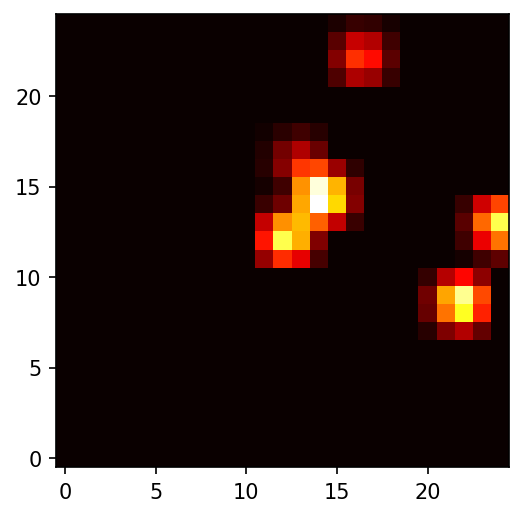

In [48]:
fig, ax = plt.subplots()


def animate(t):
    ax.cla()
    ax.imshow(selected_grid[:,:,t],origin='lower', cmap='hot')


matplotlib.animation.FuncAnimation(fig, animate, frames=25, interval = 500)